In [1]:
%pip install -q tranqu python-json-logger qulacsvis
# %pip install -q git+https://github.com/softwareQinc/staq
# %pip install ouqu-tp

Note: you may need to restart the kernel to use updated packages.


## Logging set up

In [2]:
import sys
import logging
from pythonjsonlogger import jsonlogger

class QubexFilter(logging.Filter):
    def filter(self, record):
        return record.name.startswith("qubex")

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)

log_format = '%(asctime)s %(name)s %(levelname)s %(message)s'
formatter = jsonlogger.JsonFormatter(log_format)
handler.setFormatter(formatter)

handler.addFilter(QubexFilter())
logger.addHandler(handler)

## Transpile with Tranqu

In [3]:
from qubex.circuit.dummy import DummyBackend
from tranqu import Tranqu

## Define calibration data

In [4]:
oqtopus_device ={
  "name": "1",
  "qubits": [
    {
      "id": 0,
      "physical_id": 5,
      "position": {
        "x": 3,
        "y": 0
      },
      "fidelity": 99.0,
      "meas_error": {
        "prob_meas1_prep0": 0.0,
        "prob_meas0_prep1": 0.0
      },
      "qubit_lifetime": {
        "t1": 0.0,
        "t2": 0.0
      },
      "gate_duration": {
        "rz": 0,
        "sx": 0,
        "x": 0
      }
    },
    {
      "id": 1,
      "physical_id": 7,
      "position": {
        "x": 3,
        "y": -1
      },
      "fidelity": 99.0,
      "meas_error": {
        "prob_meas1_prep0": 0.0,
        "prob_meas0_prep1": 0.0
      },
      "qubit_lifetime": {
        "t1": 0.0,
        "t2": 0.0
      },
      "gate_duration": {
        "rz": 0,
        "sx": 0,
        "x": 0
      }
    }
  ],
  "couplings": [
    {
      "control": 0,
      "target": 1,
      "fidelity": 99.0,
      "gate_duration": {
        "cx": 0,
        "rzx90": 0
      }
    }
  ],
  "timestamp": "2025-02-06 23:34:15.157724"
}

In [5]:
program = """OPENQASM 3.0;
include "stdgates.inc";
qubit[2] q;

h q[0];
cx q[0], q[1];
"""
options = {
    "basis_gates": [ "sx", "x", "rz", "cx"]
}

tranqu = Tranqu()
result = tranqu.transpile(
    program=program,
    transpiler_lib="qiskit",
    program_lib="openqasm3",
    transpiler_options=options,
    device=oqtopus_device,
    device_lib="oqtopus",
)


In [6]:
qasm_program = result.transpiled_program
print(qasm_program)

OPENQASM 3.0;
include "stdgates.inc";
rz(pi/2) $0;
sx $0;
rz(pi/2) $0;
cx $0, $1;



In [7]:
def virtual_physical_map(device_topology_json: dict):
	device_topology = device_topology_json
	qubits = {
		qubit["id"]: qubit["physical_id"] for qubit in device_topology["qubits"]
	}
	couplings = {
		(c["control"], c["target"]): (qubits[c["control"]], qubits[c["target"]])
		for c in device_topology["couplings"]
	}
	return {"qubits": qubits, "couplings": couplings}

## Create virtual-physical mapping from calibration data

In [8]:
_virtual_physical_map = virtual_physical_map(oqtopus_device)
print(_virtual_physical_map)

{'qubits': {0: 5, 1: 7}, 'couplings': {(0, 1): (5, 7)}}


## Define Qulacs Backend and Load OpenQASM3

In [9]:
backend = DummyBackend(virtual_physical_map=_virtual_physical_map)
backend.load_program(qasm_program)


{"asctime": "2025-02-09 21:21:01,710", "name": "qubex.circuit.base", "levelname": "INFO", "message": "Loading QASM 3 program: OPENQASM 3.0;\ninclude \"stdgates.inc\";\nrz(pi/2) $0;\nsx $0;\nrz(pi/2) $0;\ncx $0, $1;\n, job_id=test_job"}


In [10]:
backend.compile()

In [11]:
result = backend.execute()
print(backend.result)

{'00': 455, '01': 0, '10': 0, '11': 545}


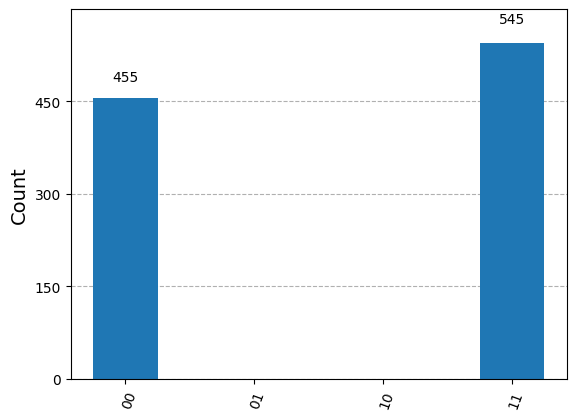

In [12]:
backend.plot_histogram()